<a href="https://colab.research.google.com/github/hrumst/ML/blob/master/ns_2_module5_hw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%config IPComplater.greedy = True

In [1]:
from google.colab import drive
drive.mount('./DRIVE', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at ./DRIVE


In [3]:
!rm -rf input && unzip "./DRIVE/My Drive/Colab Notebooks/ns-2_task-5/test.zip" -d input \
 && unzip "./DRIVE/My Drive/Colab Notebooks/ns-2_task-5/train.zip" -d input \
 && cp "./DRIVE/My Drive/Colab Notebooks/ns-2_task-5/sample-submission.csv" input \
 && cp "./DRIVE/My Drive/Colab Notebooks/ns-2_task-5/train.csv" input \
 && mv input/test_upload input/test

Archive:  ./DRIVE/My Drive/Colab Notebooks/ns-2_task-5/test.zip
   creating: input/test_upload/
  inflating: input/test_upload/97344.jpg  
  inflating: input/test_upload/48172.jpg  
  inflating: input/test_upload/86074.jpg  
  inflating: input/test_upload/95406.jpg  
  inflating: input/test_upload/52289.jpg  
  inflating: input/test_upload/87970.jpg  
  inflating: input/test_upload/54540.jpg  
  inflating: input/test_upload/3985.jpg  
  inflating: input/test_upload/5212.jpg  
  inflating: input/test_upload/89920.jpg  
  inflating: input/test_upload/298734.jpg  
  inflating: input/test_upload/307551.jpg  
  inflating: input/test_upload/42452.jpg  
  inflating: input/test_upload/29780.jpg  
  inflating: input/test_upload/67521.jpg  
  inflating: input/test_upload/69701.jpg  
  inflating: input/test_upload/35923.jpg  
  inflating: input/test_upload/58281.jpg  
  inflating: input/test_upload/29931.jpg  
  inflating: input/test_upload/38337.jpg  
  inflating: input/test_upload/91663.jpg  
 

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import pickle
import csv
import os
import tensorflow as tf

from shutil import copyfile

from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, LambdaCallback, TensorBoard
from keras.callbacks import Callback
from keras.regularizers import l2
from keras import optimizers
from keras.models import Model
from keras.utils import np_utils
from keras.applications.xception import Xception
from keras.layers import *
import keras.backend as K

from sklearn.model_selection import train_test_split, StratifiedKFold

import PIL
from PIL import ImageOps, ImageFilter
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

print(os.listdir("input"))

# чистит сессию в Keras и TF
def reset_tf_session():
    curr_session = tf.get_default_session()
    # close current session
    if curr_session is not None:
        curr_session.close()
    # reset graph
    K.clear_session()
    # create new session
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    s = tf.InteractiveSession(config=config)
    K.set_session(s)
    return s

!pip show keras

Using TensorFlow backend.


['train.csv', 'train', 'sample-submission.csv', 'test']
Name: Keras
Version: 2.2.5
Summary: Deep Learning for humans
Home-page: https://github.com/keras-team/keras
Author: Francois Chollet
Author-email: francois.chollet@gmail.com
License: MIT
Location: /usr/local/lib/python3.6/dist-packages
Requires: numpy, scipy, keras-applications, keras-preprocessing, pyyaml, h5py, six
Required-by: 


In [0]:
!rm -rf cat_input

import random
random.seed(42)

DATA_PATH = 'cat_input/'
ORIGIN_DATA_PATH = 'input/'

def copy_by_percent(src_dir, dst_dir, percent):
    for sub_dir in os.listdir(src_dir):
        sub_dir_path = os.path.join(src_dir, sub_dir)
        dst_sub_dir = os.path.join(dst_dir, sub_dir)
        if not os.path.exists(dst_sub_dir):
            os.makedirs(dst_sub_dir)
        for img in os.listdir(sub_dir_path):
            if random.randint(0,100) > percent:
                continue
            src_img_path = os.path.join(sub_dir_path, img)
            copyfile(src_img_path, os.path.join(dst_sub_dir, img))

copy_by_percent('input/train', os.path.join(DATA_PATH, 'train'), 20)

# Setup

In [0]:
# В сетап выношу основные настройки, так удобней их перебирать в дальнейшем

EPOCHS               = 20
BATCH_SIZE           = 32
LR                   = 1e-4

CLASS_NUM            = 10
IMG_SIZE             = 224
IMG_CHANNELS         = 3
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

PATH = "working/car/"

In [0]:
!rm -rf working/car/
os.makedirs(PATH,exist_ok=False)

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)

from tensorflow import set_random_seed
set_random_seed(RANDOM_SEED)

# EDA / Анализ данных

           Id  Category
0  100155.jpg         0
1  100306.jpg         0
2  100379.jpg         0
3  100380.jpg         0
4  100389.jpg         0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15561 entries, 0 to 15560
Data columns (total 2 columns):
Id          15561 non-null object
Category    15561 non-null int64
dtypes: int64(1), object(1)
memory usage: 243.2+ KB
None
1    1971
8    1765
6    1733
5    1631
0    1613
3    1528
2    1458
4    1400
9    1255
7    1207
Name: Category, dtype: int64
Пример картинок (random sample)


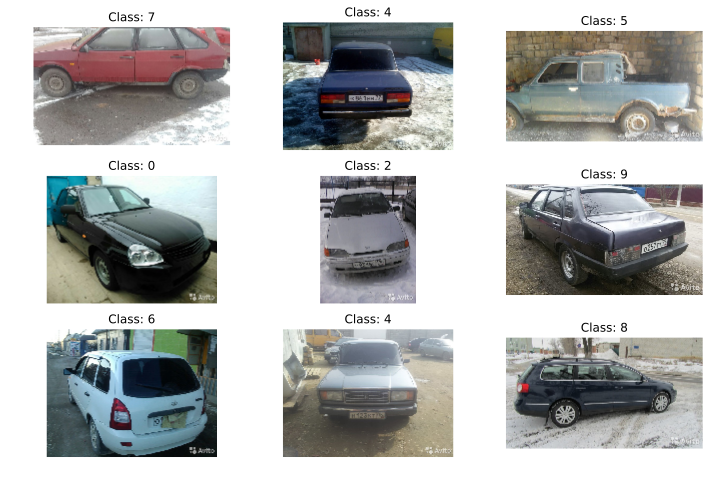

In [33]:
train_df = pd.read_csv(ORIGIN_DATA_PATH+"train.csv")
sample_submission = pd.read_csv(ORIGIN_DATA_PATH+"sample-submission.csv")
print(train_df.head())
print(train_df.info())
print(train_df.Category.value_counts())

print('Пример картинок (random sample)')
plt.figure(figsize=(12,8))

random_image = train_df.sample(n=9)
random_image_paths = random_image['Id'].values
random_image_cat = random_image['Category'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(ORIGIN_DATA_PATH+f'train/{random_image_cat[index]}/{path}')
    plt.subplot(3,3, index+1)
    plt.imshow(im)
    plt.title('Class: '+str(random_image_cat[index]))
    plt.axis('off')
plt.show()

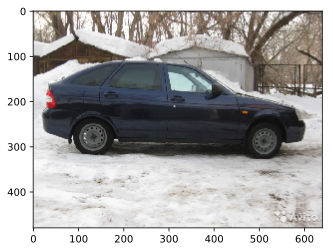

(640, 480)

In [9]:
image = PIL.Image.open(ORIGIN_DATA_PATH+'/train/0/100380.jpg')
imgplot = plt.imshow(image)
plt.show()
image.size

# Data

### Data augmentation

In [0]:
# Аугментация данных очень важна когда у нас не большой датасет (как в нашем случае)
# Поиграйся тут параметрами чтоб понять что к чему. 
# Официальная дока https://keras.io/preprocessing/image/

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range = 5,
    width_shift_range=0.1,
    height_shift_range=0.1,
    validation_split=0.1, # set validation split
    channel_shift_range=.25,
    horizontal_flip=False)

test_datagen = ImageDataGenerator(rescale=1. / 255)

# Задание для Про - попробуй подключить сторонние более продвинутые библиотеки аугминтации изображений

### datagen

In [36]:
# "Заворачиваем" наши данные в generator

train_generator = train_datagen.flow_from_directory(
    DATA_PATH+'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training') # set as training data

test_generator = train_datagen.flow_from_directory(
    DATA_PATH+'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation') # set as validation data
    

# кстати, ты заметил, что для сабмишена мы используем другой источник для генератора flow_from_dataframe? 
# Как ты думаешь, почему?

Found 2930 images belonging to 10 classes.
Found 320 images belonging to 10 classes.
Found 6675 validated image filenames.


In [17]:
!pip install tensorboardcolab
from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback
tbc=TensorBoardColab()

Wait for 8 seconds...
TensorBoard link:
http://63bc6d9c.ngrok.io


# Model

### подгружаем предобученую сеть Xception

In [0]:
# Устанавливаем новую "голову"
# Тут тоже можно поиграться, попробуй добавить Batch Normalization например.
# Кстати Попробуй еще другие архитектуры сетей...

def make_new_base_model():
    reset_tf_session()

    new_model = Xception(weights='imagenet', include_top=False, input_shape = input_shape)
    x = new_model.output

    x = GlobalAveragePooling2D()(x)
    # let's add a fully-connected layer
    x = Dense(256, activation='elu', kernel_regularizer=l2(.01), activity_regularizer=l2(.01),)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.25)(x)
    # and a logistic layer -- let's say we have 10 classes
    predictions = Dense(CLASS_NUM, activation='softmax')(x)
    return (new_model, predictions)

## Fit

In [0]:
class Model_parameters_scheduler():
    def __init__(self, target_lr, cycle_size, split=.9):
        self.target_lr = target_lr
        self.cycle_size = cycle_size
        self.split = split

    def changeTarget(self, new_target):
        self.target_lr = new_target

    def make_weight_decay_scheduler(self, w_decay_vatiants):
        steps = len(w_decay_vatiants)
        step_size = round(self.cycle_size / steps)
        next_change = 0
        step_index = 0
        
        def scheduler(batch, logs):
            nonlocal next_change
            nonlocal step_index
            if next_change > batch or step_index >= steps:
                return

            print('\nCurrent weight decay:', w_decay_vatiants[step_index])
            K.set_value(model.optimizer.decay, w_decay_vatiants[step_index])
            next_change += step_size
            step_index += 1

        return scheduler

    def make_lr_scheduler(self):

        def calculate_params():
            phase_1_end = round(self.cycle_size* self.split)
            lr_peak = round(phase_1_end / 2)
            phase_2_start = phase_1_end + 1

            lower_lr = self.target_lr * .1
            phase_2_lower_lr = lower_lr * .1
            lower_lr_step = (self.target_lr - lower_lr) / lr_peak
            phase_2_lower_lr_step = (lower_lr - phase_2_lower_lr) / (self.cycle_size - phase_2_start + 1)

            return (lr_peak, phase_2_start, lower_lr, phase_2_lower_lr, lower_lr_step, phase_2_lower_lr_step)

        def scheduler(batch, logs):
            lr_peak, phase_2_start, lower_lr, phase_2_lower_lr, lower_lr_step, phase_2_lower_lr_step = calculate_params()
            if batch == 0:
                K.set_value(model.optimizer.lr, lower_lr)
            
            new_lr = 0
            if batch < lr_peak:
                new_lr = K.get_value(model.optimizer.lr) + lower_lr_step
                K.set_value(model.optimizer.lr, new_lr)
            elif batch >= lr_peak and batch < phase_2_start:
                new_lr = K.get_value(model.optimizer.lr) - lower_lr_step
                K.set_value(model.optimizer.lr, new_lr)
            else:
                new_lr = K.get_value(model.optimizer.lr) - phase_2_lower_lr_step
                if new_lr < phase_2_lower_lr:
                    new_lr = phase_2_lower_lr
                K.set_value(model.optimizer.lr, new_lr)
            print('\nCurrent LR:', new_lr)

        return scheduler

In [0]:
base_model, predictions = make_new_base_model()
# Обучаем
# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adamax(lr=LR, decay=1e-5), metrics=["accuracy"])


# Рекомендую добавть еще функции из https://keras.io/callbacks/
checkpoint = ModelCheckpoint('best_model.hdf5' , monitor = ['val_acc'] , verbose = 1  , mode = 'max')

def batch_call(batch, logs):
    new_lr = K.get_value(model.optimizer.lr) + .0002
    K.set_value(model.optimizer.lr, new_lr)
    print(batch, 'lr:', new_lr, 'loss:', logs.get('loss'), logs)

param_scheduler = Model_parameters_scheduler(.01, len(train_generator))
    
batch_cycle_lr = LambdaCallback(on_batch_end=param_scheduler.make_lr_scheduler())
batch_w_decay = LambdaCallback(on_batch_end=param_scheduler.make_weight_decay_scheduler([1e-4,1e-5,1e-6]))
callbacks_list = [checkpoint, batch_cycle_lr, batch_w_decay, TensorBoardColabCallback(tbc)]

# Для про - попробуй добавить разные техники управления Learning Rate
# Например:
# https://towardsdatascience.com/finding-good-learning-rate-and-the-one-cycle-policy-7159fe1db5d6
# http://teleported.in/posts/cyclic-learning-rate/

def train_phase_simple(epochs):
    model.fit_generator(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_generator, 
        validation_steps = len(test_generator),
        epochs = epochs,
        callbacks = callbacks_list
    )

def train_phase_with_unfreeze(epochs, unfreeze_layers, new_lr_target=None):
    if new_lr_target is not None:
        param_scheduler.changeTarget(new_lr_target)
    # все слои обучаемы
    for layer in model.layers:
        layer.trainable = True
        if isinstance(layer, BatchNormalization):
            # быстрее настраиваем параметры батч норма!
            layer.momentum = 0.9
        
    # fine-tuning только для 50 последних слоев
    for layer in model.layers[:-unfreeze_layers]:
        # батч норм должен настраивать свои параметры для новых данных! а иначе фиксируем слой!
        if not isinstance(layer, BatchNormalization):
            layer.trainable = False

    model.fit_generator(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_generator, 
        validation_steps = len(test_generator),
        epochs = epochs,
        callbacks = callbacks_list
    )

# попробуй применить transfer learning с fine-tuning
# Сначала замораживаем все слои кроме новой "головы"
# Потом, когда мы научили последние слои (голову) под новую задачу, можно разморозить все слои и пройтись маленьким лернинг рейтом
train_phase_with_unfreeze(5, 25, .05)
train_phase_with_unfreeze(5, 50, .005)
train_phase_with_unfreeze(5, 75, .001)

In [0]:
model.save('../working/model_last.hdf5')
model.load_weights('best_model.hdf5')

In [0]:
scores = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

# Submission

In [73]:
test_sub_generator = test_datagen.flow_from_dataframe(
    dataframe=sample_submission,
    directory=ORIGIN_DATA_PATH+'test',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)


test_sub_generator.samples

Found 6675 validated image filenames.


6675

In [0]:
test_sub_generator.reset()
predictions = model.predict_generator(test_sub_generator, steps=len(test_sub_generator), verbose=1) 
predictions = np.argmax(predictions, axis=-1) #multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]

In [0]:
filenames_with_dir=test_sub_generator.filenames
submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/','')
submission.to_csv('submission.csv', index=False)
print('Save submit')

# Для Про - попробуй TTA

In [0]:
submission.head()

In [0]:
# make a prediction using test-time augmentation
def tta_prediction(datagen, model, image, n_examples):
	# convert image into dataset
	samples = expand_dims(image, 0)
	# prepare iterator
	it = datagen.flow(samples, batch_size=n_examples)
	# make predictions for each augmented image
	yhats = model.predict_generator(it, steps=n_examples, verbose=0)
	# sum across predictions
	summed = numpy.sum(yhats, axis=0)
	# argmax across classes
	return argmax(summed)
 
# evaluate a model on a dataset using test-time augmentation
def tta_evaluate_model(model, testX, testY):
	# configure image data augmentation
	datagen = ImageDataGenerator(horizontal_flip=True)
	# define the number of augmented images to generate per test set image
	n_examples_per_image = 7
	yhats = list()
	for i in range(len(testX)):
		# make augmented prediction
		yhat = tta_prediction(datagen, model, testX[i], n_examples_per_image)
		# store for evaluation
		yhats.append(yhat)
	# calculate accuracy
	testY_labels = argmax(testY, axis=1)
	acc = accuracy_score(testY_labels, yhats)
	return acc

## Интересно, к какому классу модель отнесет вот этот авто:
![](http://kvu.su/upload/iblock/e3a/e3a32ed064fd71e4ce99b7f57d2de745.jpg)